In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.counter = collections.Counter()
        self.total = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1

        token_id = self.word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return token_id

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))
        self.num_tokens = len(self.dictionary)

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids
    
# https://github.com/fastai/fastai_docs/blob/master/dev_nb/007_wikitext_2.ipynb
# download data from https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
EOS = '<eos>'
PATH=Path('')

def read_file(filename):
    tokens = []
    with open(PATH/filename, encoding='utf8') as f:
        for line in f:
            tokens.append(line.split() + [EOS])
    return np.array(tokens)

In [71]:
train_tok = read_file('train.txt')
valid_tok = read_file('valid.txt')
test_tok = read_file('test.txt')

# cor = Corpus('')
# voc = Vocab(cor.dictionary.idx2word)

In [61]:
len(voc.itos)

18176

In [59]:
voc.itos

['<eos>',
 'Being',
 'Peace',
 'THICH',
 'NHAT',
 'HANH',
 'Illustrated',
 'by',
 'Mayumi',
 'Oda',
 'Introduction',
 'Jack',
 'Kornfield',
 'PARALLAX',
 'PRESS',
 'BERKELEY,',
 'CALIFORNIA',
 'Parallax',
 'Press',
 'P.O.',
 'Box',
 '735',
 '5',
 'Berkeley,',
 'California',
 '94707',
 'www.parallax.org',
 'is',
 'the',
 'publishing',
 'division',
 'of',
 'Unified',
 'Buddhist',
 'Church,',
 'Inc.',
 'Copyright',
 '©',
 '1987,',
 '2005',
 'Church.',
 'All',
 'rights',
 'reserved.',
 'Printed',
 'in',
 'United',
 'States',
 'America',
 'on',
 '50%',
 'recycled',
 'paper.',
 'Original',
 'edition',
 'edited',
 'Arnold',
 'Kotler.',
 'New',
 'Rachel',
 'Neumann.',
 'Cover',
 'and',
 'text',
 'design',
 'Copa',
 '&',
 'Ted',
 '2,',
 'Illustrations',
 '1987',
 'Oda.',
 'The',
 'drawings',
 'were',
 'created',
 'specifically',
 'for',
 'this',
 'book.',
 'Please',
 'do',
 'not',
 'photo\xad',
 'copy',
 'or',
 'otherwise',
 'reproduce',
 'them',
 'any',
 'purposes',
 'whatsoever.',
 'Library',

In [5]:
a = list(train_tok)

In [6]:
flat_list = [item for sublist in a for item in sublist]

In [7]:
len(flat_list)
# 600k tokens
# * 2 ~ ptb
# * 5 ~ wikitext-2
# * 300 ~ wikitext-103

602169

In [29]:
train_tok

array([list(['<eos>']), list(['<eos>']), list(['<eos>']), list(['<eos>']), ...,
       list(['Tel:', '(760)', '291–1003', '<eos>']), list(['Fax:', '(760)', '291–1172', '<eos>']),
       list(['Deerpark@plumvillage.org', '<eos>']), list(['<eos>'])], dtype=object)

In [42]:
36000*30

1080000

In [8]:
bs = 256
bptt = 35

In [72]:
dat = TextLMDataBunch.from_tokens('data', 
                                  trn_tok = train_tok, trn_lbls = None,
                                  val_tok = valid_tok, val_lbls=None,
                                  tst_tok = test_tok, 
#                                   vocab = voc,
                                  bs = bs, bptt = bptt)

In [10]:
# [] list has some method
# voc.itos is a list so it has those default method

In [73]:
dat.train_ds

LabelList (58665 items)
x: LMTextList
<eos>,<eos>,<eos>,<eos>,<eos>
y: LMLabelList
,,,,
Path: data

In [63]:
# pdftotext create incorrect positioned <eos> tokens
dat.show_batch()

idx,text
0,Weight Control <eos> CHAPTER 1 Ending Your Struggle with Weight <eos> CHAPTER 2 Are You Really Appreciating the Apple? <eos> An Apple Meditation <eos> CHAPTER 3 You Are More Than What You Eat <eos> CHAPTER
1,"up Savor because <eos> you or someone you love is struggling with weight and in need of practical <eos> solutions, then this book is for you also. <eos> Learning to eat and live mindfully is"
2,"without judgment or preconceived notions. <eos> Although mindfulness has been taught in Eastern meditation trainings, it is not <eos> some mystical or esoteric practice that is hard to learn. People in all walks of life"
3,"to a healthy lifestyle and weight control. You can start <eos> to make changes step-by-step, establishing healthier habits and instilling more and <eos> more peace within yourself. <eos> With the hectic pace of modern living,"
4,"<eos> become overweight, if you so choose. And you will realize that mindfulness <eos> practice is an e ective path toward a healthier way of living and a healthier <eos> weight. <eos> Next, we o"


In [84]:
learn = language_model_learner(dat, AWD_LSTM, drop_mult=0.3)

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


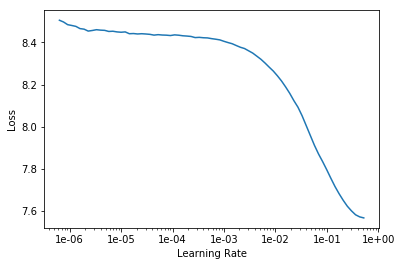

In [60]:
learn.recorder.plot(skip_end=15)

In [85]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.764505,4.785035,0.200391,00:40


In [86]:
learn.unfreeze()

In [87]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.002416,4.661658,0.198047,00:51
1,4.765225,6.143834,0.059487,00:51
2,4.525428,6.491889,0.049219,00:51
3,4.319672,6.588002,0.048047,00:51
4,4.220716,4.896412,0.121373,00:51


In [81]:
TEXT = "Anger is good."
N_WORDS = 500
N_SENTENCES = 1

In [88]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Anger is good. <eos> through the possibility of reaching real us. <eos> an e fear, in our heart, we need to be in touch with our own <eos> to guide them in finding food and <eos> the path of liberation from birth and death. <eos> <eos> and place the seed of mindfulness. You are the one who <eos> the time, we are wandering in a hurry and <eos> “Your practice is a wonderful way to practice meditation and <eos> of the Way of Touching the The river of enlightenment <eos> the village to sit down and read a little sensitive to the <eos> the situation has been interrupted and even the people of people <eos> at that moment in our room so that we can see it in a <eos> being. <eos> don’t look deeply into it, and you know how important it is to <eos> the seed of anger in the rain. You are in <eos> the name of the Buddha and the infinite, wrong <eos> the more you in, the more you become the more you can <eos> refuge in the monastery because the people her ability to eat is a <eos> t which is alrea

In [37]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Anger Chapter West - said, words. The Buddha told the Buddha that the Buddha had preparing them for a special meal in the future. The Buddha said, Only our friend King Bimbisara is a great All a spiritual Rahula, and the senior bhikkhu in his nation would be the Buddha’s The
Anger you are a long time in your daily heart. If you are fully awakened and at that moment you are suddenly the same or Buddha, I will never forget that you are I take the time to tell you about the Buddha in the very nature of his own body,
